# Jupyter Notebook Testing Demographics in OG-UK
This notebook tests the `demographics.py` file in the `oguk` package against the similar file in the `ogusa` package.

In [1]:
# Import packages
import numpy as np
import scipy.optimize as opt
import pandas as pd
import eurostat
from oguk import demographics as dmg
import matplotlib.pyplot as plt

Create a function
\begin{equation}
  \begin{split}
  births = a * (age^b) + c \quad\text{for}\quad age\in[50, 60] \\
  \text{s.t.}\quad a * (49^b) + c = births(49) \\
  \text{and}\quad a * (60^b) + c = 1 \\
  \text{and}\quad \sum_{age=50}^{60}\left(a * (age^b) + c\right) = 263
  \end{split}
\end{equation}

In [2]:
save_data_path = ("/Users/richardevans/Documents/Economics/OSE/OG-UK/" +
                  "oguk/data/demographic")
plot_data_path = ("/Users/richardevans/Documents/Economics/OSE/OG-UK/" +
                  "oguk/images/demographic/fert_rates_maxyr.png")
fert_rates_maxyr = dmg.get_fert(100, 2018, 0, 99)

using csv saved fertility rates by age data


TypeError: expected str, bytes or os.PathLike object, not NoneType

## 1. Test get_fert()

In [3]:
def exp_b_zerofunc(b, *args):
    """
    This function is the target of the root finder that solves for the exponent
    b in the following functional form:

    .. math::
        &y &= a * (x ** b) + c \quad for x\in[x0, x_N] \\
        \text{such that}\quad &a * x_0^b + c = y0, \\
        \text{and}\quad &a * (x_N ** b) + c = 1 \\
        \text{and}\quad &\sum_{x=x_1}^{x_N} [a x^b + c] = y_{lastbin}

    Args:
        b (scalar): value of b exponent in exponential functional form
        args (4-element tuple): arguments to solve for error function

    Returns:
        error_val (scalar): Error of zero function associated with solution for
            b
    """
    (x0, xN, y0, y_lastbin) = args
    if xN > x0:
        distribute_up = True
        step = 1
    elif xN < x0:
        distribute_up = False
        step = -1
    elif xN == x0:
        err_message = "ERROR exp_b_zerofunc(): xN equals x0."
        raise ValueError(err_message)
    x1 = x0 + step
    a = (y0 - 1) / ((x0 ** b) - (xN ** b))
    c = 1 - (a * (xN ** b))
    sum_y = 0
    for x in range(x1, xN + step, step):
        sum_y += (a * (x ** b)) + c
    error_val = sum_y - y_lastbin

    return error_val


def distribute_bin(args):
    """
    This function is for distributing aggregated bin data values across
    disaggregated bins according to a monotonically decreasing (or increasing)
    function depending on whether we are distributing bins up (or down). The
    functional form is the following:

    .. math::
        &y &= a * (x ** b) + c \quad for x\in[x0, x_N] \\
        \text{such that}\quad &a * x_0^b + c = y0, \\
        \text{and}\quad &a * (x_N ** b) + c = 1 \\
        \text{and}\quad &\sum_{x=x_1}^{x_N} [a x^b + c] = y_{lastbin}

    Args:
        x0 (int): end x-value to which imputed function must connect
        xN (int): last positive x_value at which imputed function must finish
        xmax (int): for monotonically decreasing (or increasing) function,
            distributing up (down), the maximum (or minimum) value that can
            have a positive value if xN is not high (low) enough
        y0 (scalar): end y-value to which imputed function must connect
        y_lastbin (scalar): total aggregated-bins y-value, to which the sum of
            imputed function values must equal

    Returns:
        x_vec (array_like): array of imputed x-values in ascending order
            (x1,...xN) for distributed-up problem and (xN,...x1) for
            distributed-down problem
        y_vec (array_like): array of imputed y-values in corresponding to x_vec
        abc_vec (array_like): array of estimated values for (a, b, c)
        xN_new (int): updated value for xN
    """
    (x0, xN, xmax, y0, y_lastbin) = args
    if xN > x0:
        distribute_up = True
        if xmax < xN:
            err_message = (
                "Error distribute_bin(): xmax < xN for "
                + "distribute_up=True."
            )
            raise ValueError(err_message)
        step = 1
    elif xN < x0:
        distribute_up = False
        if xmax > xN:
            err_message = (
                "Error distribute_bin(): xmax > xN for "
                + "distribute_up=False."
            )
            raise ValueError(err_message)
        step = -1
    elif xN == x0:
        err_message = "ERROR distribute_bin(): xN equals x0."
        raise ValueError(err_message)
    else:
        err_message(
            "ERROR distribute_bin(): xN is neither greater-than, "
            + "less-than, or equal to x0 in absolute value."
        )
        print("xN=", xN, ", x0=", x0, ", xN-x0=", xN - x0)
        raise ValueError(err_message)
    x1 = x0 + step
    # Check if a line a * x + c from x0, y0 to xN, 1 sums up to something
    # greater-than-or-equal to y_lastbin
    lin0 = False
    xN_new = xN
    while not lin0 and step * xN_new <= step * xmax:
        sum_y_lin0 = 0
        a_lin0 = (1 - y0) / (xN_new - x0)
        c_lin0 = 1 - (a_lin0 * xN_new)
        for x in range(x1, xN_new + step, step):
            sum_y_lin0 += (a_lin0 * x) + c_lin0
        lin0 = sum_y_lin0 >= y_lastbin
        print("Sum of lin0 model =", sum_y_lin0, "for xN=", xN_new)
        print("Sum of lin0 model >=", y_lastbin, "=", lin0)
        if not lin0:
            xN_new += step

    if step * xN_new > step * xN:
        if distribute_up:
            print("NOTE (distribute_bin()): xN value was increased.")
        else:
            print("NOTE (distribute_bin()): xN value was decreased.")

    if step * xN_new > step * xmax:
        xN_new += -step

    if not lin0 and step * xN_new == step * xmax:
        # Distribute final bin as a line from (x0, y0) to xmax and the ymax
        # value that makes the sum equal to y_lastbin
        b = 1.0
        a = (y_lastbin - (step * (xmax - x0) * y0)) / (
            np.arange(x1, xmax + step, step).sum() - (step * (xmax - x0) * x0)
        )
        c = y0 - a * x0

    elif lin0 and sum_y_lin0 == y_lastbin:
        # If sum_y_lin0 is exactly equal to y_lastbin, set the interpolated y
        # values as a line from (x0, y0) to (xN_new, 1)
        b = 1.0
        a = a_lin0
        c = c_lin0

    elif lin0 and sum_y_lin0 > y_lastbin:
        # Estimate b in three paramter function a * (x ** b) + c
        # such that a * (xN_new ** b) + c = 1,
        # a * (x0 ** b) + c = y0, and
        # sum_{x=x1}^xN_new (a * (x ** b) + c) = y_lastbin
        print("distribute_bin(): Fitting three-parameter function.")
        b_args = (x0, xN_new, y0, y_lastbin)
        b_sol = opt.root(exp_b_zerofunc, x0=1.0, args=b_args)
        b = b_sol.x[0]
        print("b_sol.success=", b_sol.success)
        a = (y0 - 1) / ((x0 ** b) - (xN_new ** b))
        c = 1 - (a * (xN_new ** b))

    if distribute_up:
        x_vec = np.arange(x1, xN_new + 1)
    else:
        x_vec = np.arange(xN_new, x1 + 1)
    y_vec = (a * (x_vec ** b)) + c
    abc_vec = np.array([a, b, c])

    return x_vec, y_vec, abc_vec, xN_new

In [4]:
# Test Eurostat download info
Country = "UK"
Year = 2018
StartPeriod = Year
EndPeriod = Year
filter_pars = {"GEO": [Country]}
df_pop = eurostat.get_sdmx_data_df(
    "demo_pjan",
    StartPeriod,
    EndPeriod,
    filter_pars,
    flags=True,
    verbose=True
)

Progress: 100.0%


In [5]:
# Remove totals and other unused rows
indexNames = df_pop[
    (df_pop["AGE"] == "TOTAL")
    | (df_pop["AGE"] == "UNK")
    | (df_pop["AGE"] == "Y_OPEN")
].index
df_pop.drop(indexNames, inplace=True)

# Rename Y_LT1 to 0 (means 'less than one year')
df_pop.AGE[df_pop.AGE == "Y_LT1"] = "Y0"

#  Remove leading 'Y' from 'AGE' (e.g. 'Y23' --> '23')
df_pop["AGE"] = df_pop["AGE"].str[1:]

# Drop gender specific population, keep only total
df_pop = df_pop[(df_pop["SEX"] == "T")]

# Name of 1 column includes the year - create column name before
# dropping
Obs_status_col = str(Year) + "_OBS_STATUS"
# Drop columns except: Age, Frequency
df_pop = df_pop.drop(
    columns=["UNIT", "SEX", "GEO", "FREQ", Obs_status_col]
)

# rename population total series "POP" instead of the year
df_pop.rename(columns={Year: "POP"}, inplace=True)

# convert AGE strings to int and Year strings to float
df_pop = df_pop.astype(float)
df_pop["AGE"] = df_pop["AGE"].astype(int)

# sort values by AGE and reindex the DataFrame
df_pop = df_pop.sort_values(by=["AGE"])
df_pop.reset_index(drop=True, inplace=True)

In [6]:
df_pop.dtypes

AGE      int64
POP    float64
dtype: object

In [7]:
df_pop.describe()

,AGE,POP
count,100.000000,100.000000
mean,49.500000,662591.070000
std,29.011492,280530.299548
min,0.000000,7896.000000
25%,24.750000,541369.000000
50%,49.500000,779702.500000
75%,74.250000,874524.500000
max,99.000000,940124.000000


In [8]:
df_pop['AGE'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

Text(0, 0.5, 'Population')

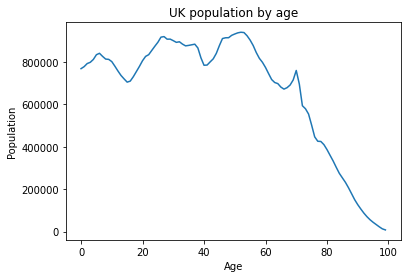

In [9]:
plt.plot(df_pop['AGE'], df_pop['POP'])
plt.title('UK population by age')
plt.xlabel('Age')
plt.ylabel('Population')

In [10]:
df_pop

,AGE,POP
0,0,768431.0
1,1,777830.0
2,2,792428.0
3,3,798299.0
4,4,811766.0
...,...,...
95,95,43875.0
96,96,33235.0
97,97,22628.0
98,98,12940.0


In [11]:
df_births = eurostat.get_sdmx_data_df(
    "demo_fasec",
    StartPeriod,
    EndPeriod,
    filter_pars,
    flags=True,
    verbose=True,
)

Progress: 100.0%


In [12]:
max_yr = 99

In [13]:
# Select Sex = T (meaning "Total" of boys and girls born); drop others
df_births = df_births[(df_births["SEX"] == "T")]

# Drop columns except: Age, Frequency
df_births = df_births.drop(
    columns=["UNIT", "SEX", "GEO", "FREQ", Obs_status_col]
)
# rename total births series "BIRTHS" instead of the year
df_births.rename(columns={Year: "BIRTHS"}, inplace=True)

# Remove remaining total and subtotals
indexNames = df_births[
    (df_births["AGE"] == "TOTAL")
    | (df_births["AGE"] == "UNK")
    | (df_births["AGE"] == "Y15-19")
    | (df_births["AGE"] == "Y20-24")
    | (df_births["AGE"] == "Y25-29")
    | (df_births["AGE"] == "Y30-34")
    | (df_births["AGE"] == "Y35-39")
    | (df_births["AGE"] == "Y40-44")
    | (df_births["AGE"] == "Y45-49")
].index
df_births.drop(indexNames, inplace=True)

# Rename Y10-14 to Y14 and rename Y_GE50 to Y50
df_births["AGE"].replace("Y10-14", "Y14", inplace=True)
df_births["AGE"].replace("Y_GE50", "Y50", inplace=True)

#  Remove leading 'Y' from 'AGE' (e.g. 'Y23' --> '23')
df_births["AGE"] = df_births["AGE"].str[1:]
# Convert AGE variable to int and reset index
df_births["AGE"] = df_births["AGE"].astype(int)
df_births.reset_index(drop=True, inplace=True)

# Spread the births that were in Y_GE50 (now Y50) among ages 50 through
# 57 (births=0 for age >=58) using a negative exponential function of
# the form BIRTHS_AGE = a * (AGE ** b) + c for AGE = 50, 51, ... 57
age_Tup = 49
births_Tup = df_births.loc[
    df_births["AGE"] == age_Tup, "BIRTHS"
].values.astype(float)[0]
age_lastpos_up = 57
age_max_up = 65
births_lastbin_up = df_births.loc[
    df_births["AGE"] == age_Tup + 1, "BIRTHS"
].values.astype(float)[0]
bdup_args = (
    age_Tup,
    age_lastpos_up,
    age_max_up,
    births_Tup,
    births_lastbin_up,
)
age_vec_up, births_vec_up, abc_vec_up, age_lastpos_up = distribute_bin(
    bdup_args
)
df_births_up = pd.DataFrame(
    np.hstack(
        (
            age_vec_up.reshape(len(age_vec_up), 1),
            births_vec_up.reshape(len(births_vec_up), 1),
        )
    ),
    columns=["AGE", "BIRTHS"],
)
df_births = pd.concat(
    [df_births[df_births["AGE"] <= age_Tup], df_births_up],
    ignore_index=True,
)

# Spread the births that were in Y10-14 (now Y14) among ages 10 through
# 14 (births=0 for age <=9) using an exponential function of the form
# BIRTHS_AGE = a * (AGE ** b) + c for AGE = 10, 11, ... 15
age_Tdn = 15
births_Tdn = df_births.loc[
    df_births["AGE"] == age_Tdn, "BIRTHS"
].values.astype(float)[0]
age_lastpos_dn = 10
age_min_dn = 8
births_lastbin_dn = df_births.loc[
    df_births["AGE"] == age_Tdn - 1, "BIRTHS"
].values.astype(float)[0]
bddn_args = (
    age_Tdn,
    age_lastpos_dn,
    age_min_dn,
    births_Tdn,
    births_lastbin_dn,
)
age_vec_dn, births_vec_dn, abc_vec_dn, age_lastpos_dn = distribute_bin(
    bddn_args
)
df_births_dn = pd.DataFrame(
    np.hstack(
        (
            age_vec_dn.reshape(len(age_vec_dn), 1),
            births_vec_dn.reshape(len(births_vec_dn), 1),
        )
    ),
    columns=["AGE", "BIRTHS"],
)
df_births = pd.concat(
    [df_births_dn, df_births[df_births["AGE"] >= age_Tdn]],
    ignore_index=True,
)

# Concatenate missing years with zero births at beginning and end of
# df_births dataframe
df_zeros_a = pd.DataFrame(
    np.hstack(
        (
            np.arange(age_lastpos_dn).reshape(age_lastpos_dn, 1),
            np.zeros((age_lastpos_dn, 1)),
        )
    ),
    columns=["AGE", "BIRTHS"],
)
df_zeros_z = pd.DataFrame(
    np.hstack(
        (
            np.arange(age_lastpos_up + 1, max_yr + 1).reshape(
                max_yr - age_lastpos_up, 1
            ),
            np.zeros((max_yr - age_lastpos_up, 1)),
        )
    ),
    columns=["AGE", "BIRTHS"],
)
df_births = pd.concat(
    [df_zeros_a, df_births, df_zeros_z], ignore_index=True
)

# sort values by AGE
df_births = df_births.sort_values(by=["AGE"])

Sum of lin0 model = 533.0 for xN= 57
Sum of lin0 model >= 263.0 = True
distribute_bin(): Fitting three-parameter function.
b_sol.success= True
Sum of lin0 model = 622.9999999999998 for xN= 10
Sum of lin0 model >= 73.0 = True
distribute_bin(): Fitting three-parameter function.
b_sol.success= True


In [14]:
df_births

,AGE,BIRTHS
0,0.0,0.0
1,1.0,0.0
2,2.0,0.0
3,3.0,0.0
4,4.0,0.0
...,...,...
95,95.0,0.0
96,96.0,0.0
97,97.0,0.0
98,98.0,0.0


Text(0, 0.5, 'Births')

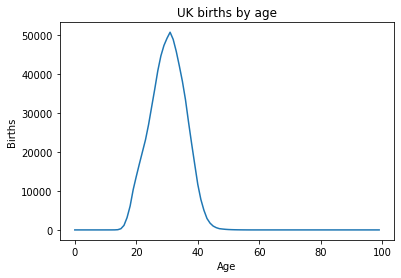

In [15]:
plt.plot(df_births['AGE'], df_births['BIRTHS'])
plt.title('UK births by age')
plt.xlabel('Age')
plt.ylabel('Births')

In [ ]:
# births_vec = df_births["BIRTHS"].to_numpy()
# type(births_vec)
# pop_vec = df_pop["POP"].to_numpy()
fert_rates100 = df_births["BIRTHS"].to_numpy(dtype="float64") / df_pop["POP"].to_numpy(dtype="float64")
# fert_rates100 = births_vec / pop_vec
# df_births["BIRTHS"].to_numpy()
# type(df_births["BIRTHS"].to_numpy())
# type(df_pop["POP"].to_numpy())
# df_pop["POP"].to_numpy()
fert_rates100.shape

In [ ]:
# Test get_fert
totpers = 100
base_yr = 2012
fert_rates = dmg.get_fert(totpers, base_yr, download=True)
print('fert_rates shape =', fert_rates.shape)
print(fert_rates)

In [ ]:
# Plot fertility rates by period
plt.plot(np.arange(totpers), fert_rates)
plt.title('Fertility rates in OG-UK (' + str(base_yr) + ')')
plt.xlabel('Age (years)')
plt.ylabel('fertility rate')

## 2. Test get_mort()